In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Checking for NAs

In [4]:
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()],
                axis=1,
                keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
MSZoning,0,4.0
LotFrontage,259,227.0
Alley,1369,1352.0
Utilities,0,2.0
Exterior1st,0,1.0
Exterior2nd,0,1.0
MasVnrType,8,16.0
MasVnrArea,8,15.0
BsmtQual,37,44.0
BsmtCond,37,45.0


### Importing my functions

In [5]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    print("Train")
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

### Splitting to features and labels and deleting variables I don't need

In [6]:
# Spliting to features and lables and deleting variable I don't need
train_labels = train.pop('SalePrice')

train['trainset'] = 1
test['trainset'] = 0

features = pd.concat([train, test], ignore_index=True)

# I decided to get rid of features that have more than half of missing information or do not correlate to SalePrice
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1,
              inplace=True)

### Filling NAs and converting features

In [7]:
features.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,trainset
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,856.0,Ex,Y,SBrkr,856,854,1710,2,1,3,1,Gd,8,0,NaN,Attchd,RFn,2.0,TA,Y,2,2008,WD,Normal,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,1262.0,Ex,Y,SBrkr,1262,0,1262,2,0,3,1,TA,6,1,TA,Attchd,RFn,2.0,TA,Y,5,2007,WD,Normal,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,920.0,Ex,Y,SBrkr,920,866,1786,2,1,3,1,Gd,6,1,TA,Attchd,RFn,2.0,TA,Y,9,2008,WD,Normal,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,756.0,Gd,Y,SBrkr,961,756,1717,1,0,3,1,Gd,7,1,Gd,Detchd,Unf,3.0,TA,Y,2,2006,WD,Abnorml,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,1145.0,Ex,Y,SBrkr,1145,1053,2198,2,1,4,1,Gd,9,1,TA,Attchd,RFn,3.0,TA,Y,12,2008,WD,Normal,1


In [8]:
# 住宅类型
# MSSubClass as str
features['MSSubClass'] = features['MSSubClass'].astype(str)

# 区域
# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# 通往房产的小径类型
# Alley  NA in all. NA means no access
features['Alley'] = features['Alley'].fillna('NOACCESS')

# 整体条件
# Converting OverallCond to str
features.OverallCond = features.OverallCond.astype(str)

# 石面类型
# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# 地下室相关
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# 地下室面积
# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# 电力类型
# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenAbvGr to categorical
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

# 厨房质量
# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# 壁炉质量
# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# 车库相关
# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

# 车库容量
# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# 销售类型
# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# 年售 月售
# Year and Month to categorical
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# 地下室面积，第一层面积，第二层面积
# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

### Log transformation

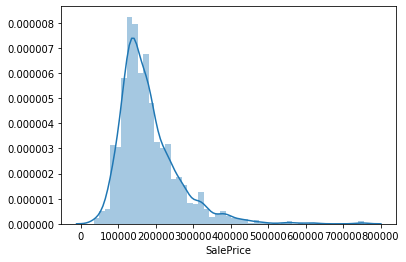

In [9]:
# Our SalesPrice is skewed right (check plot below). I'm logtransforming it. 
ax = sns.distplot(train_labels)

In [10]:
# Log transformation of labels
train_labels = np.log(train_labels)

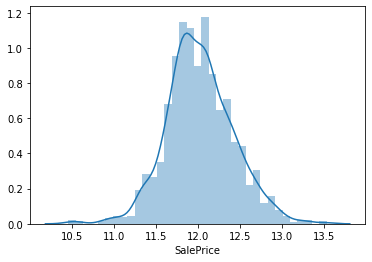

In [11]:
# Now it looks much better
ax = sns.distplot(train_labels)

### Standardizing numeric data

In [12]:
# Standardizing numeric features
numeric_features = features.loc[:, ['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()

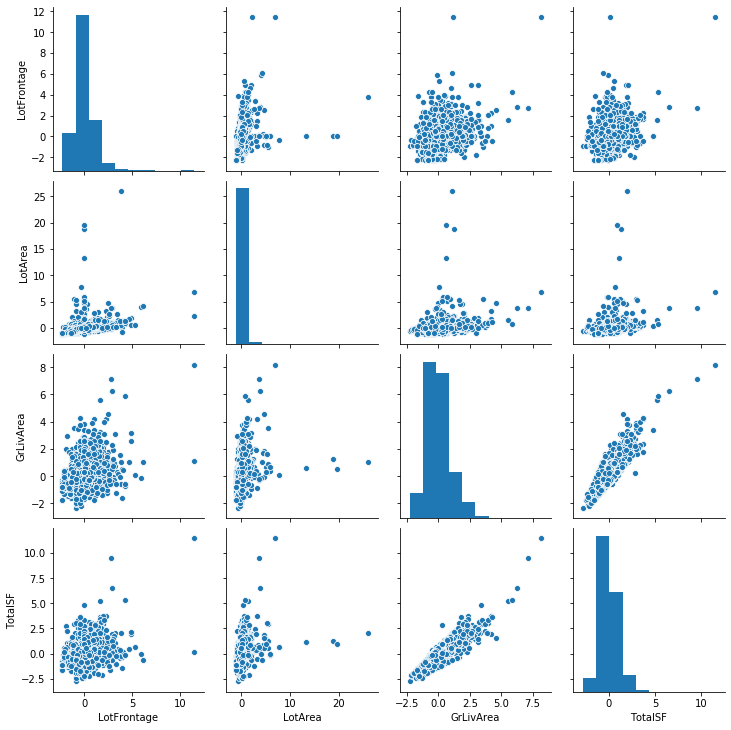

In [13]:
ax = sns.pairplot(numeric_features_standardized)

### Converting categorical data to dummies

In [14]:
# Getting Dummies from Condition1 and Condition2
conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
                       index=features.index, columns=conditions)
for i, cond in enumerate(zip(features['Condition1'], features['Condition2'])):
    dummies.loc[i, cond[0]] = 1
    dummies.loc[i, cond[1]] = 1
features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

# Getting Dummies from Exterior1st and Exterior2nd
exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
                       index=features.index, columns=exteriors)
for i, ext in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
    dummies.loc[i, ext[0]] = 1
    dummies.loc[i, ext[1]] = 1
features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd', 'Exterior_nan'], axis=1, inplace=True)

# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

### Obtaining standardized dataset

In [15]:
# Copying features
features_standardized = features.copy()

# Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)

### Splitting train and test features

In [16]:
# Splitting features
train_features = features[features['trainset'] == 1].drop(['Id', 'trainset'], axis=1).select_dtypes(include=[np.number]).values
test_features = features[features['trainset'] == 0].drop(['Id', 'trainset'], axis=1).select_dtypes(include=[np.number]).values

# Splitting standardized features
train_features_st = features[features['trainset'] == 1].drop(['Id', 'trainset'], axis=1).select_dtypes(include=[np.number]).values
test_features_st = features[features['trainset'] == 0].drop(['Id', 'trainset'], axis=1).select_dtypes(include=[np.number]).values

### Splitting to train and validation sets

In [17]:
# Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state=2020)

In [18]:
# Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=2020)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=2020)

## First level models

My analysis revealed that Gradient Boosting and Elastic Net (using Standardized Features) show best results.

### Elastic Net
I'm using ElasticNetCV estimator to choose best alpha and l1_ratio for my Elastic Net model.

In [19]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train_st, y_train_st)
train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
             cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)
Train
R2: 0.90040912166225
RMSE: 0.11889489710706898
Test
R2: 0.9166230958083755
RMSE: 0.10793250335105362


In [20]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(ENSTest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.11)


### Gradient Boosting

We use a lot of features and have many outliers. So I'm using max_features='sqrt' to reduce overfitting of my model. I also use loss='huber' because it more tolerant to outliers. All other hyper-parameters was chosen using GridSearchCV.

In [21]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                           min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GBest, x_train, x_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='huber',
                          max_depth=3, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Train
R2: 0.9609100270302695
RMSE: 0.07625156566718821
Test
R2: 0.9142639683546916
RMSE: 0.10977396969881599


In [22]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(GBest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.07)


## Ensembling final model

My final ensemble model is an average of Gradient Boosting and Elastic Net predictions. But before that I retrained my models on all train data.

In [23]:
# Retraining models
GB_model = GBest.fit(train_features, train_labels)
ENST_model = ENSTest.fit(train_features_st, train_labels)

In [24]:
# Getting our SalePrice estimation
Final_labels = (np.exp(GB_model.predict(test_features)) + np.exp(ENST_model.predict(test_features_st))) / 2

In [25]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': Final_labels}).to_csv('2017-02-28.csv', index =False)